In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import backend

tf.config.run_functions_eagerly(True)

2022-09-29 16:25:18.855752: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix, brier_score_loss, log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from keras_unet_collection import utils as k_utils

sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

In [46]:
def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [4]:
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config

In [5]:
# with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
#     lon_3km = h5io['lon_3km'][...]
#     lat_3km = h5io['lat_3km'][...]
#     lon_72km = h5io['lon_72km'][...]
#     lat_72km = h5io['lat_72km'][...]
#     land_mask_72km = h5io['land_mask_72km'][...]
#     land_mask_3km = h5io['land_mask_3km'][...]

In [6]:
ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
L_vars = len(ind_pick_from_batch)

In [7]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead2.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*lead2.npy"))
filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*lead2.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*lead2.npy"))

In [51]:
filename_train = filename_neg_train+filename_pos_train

In [8]:
filename_valid = filename_neg_valid[::40] + filename_pos_valid[::40]

In [9]:
L_valid = len(filename_valid)
L_var = L_vars

TEST_input = np.empty((L_valid, 64, 64, L_var))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        TEST_input[i, ..., k] = data[..., c]

        if 'pos' in name:
            TEST_target[i] = 1.0
        else:
            TEST_target[i] = 0.0

In [10]:
TEST_input.shape

(8267, 64, 64, 15)

In [11]:
np.sum(TEST_target) / len(TEST_target)

0.0014515543728075482

**BBN-ConvNext**

In [57]:
depths=[3, 3, 27, 3]
projection_dims=[96, 192, 384, 768]
layer_scale_init_value=1e-6
input_shape=(64, 64, 15)
#model_name='BBN'

In [58]:
def BBN_share(IN, depths, projection_dims, layer_scale_init_value, model_name):
    
    X = IN
    
    X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

    for j in range(depths[0]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                                   groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext


    # ----- convnext block 1 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

    for j in range(depths[1]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                                   groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext

    # ----- convnext block 2 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

    for j in range(depths[2]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=7, padding="same",
                                   groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

        X = X + X_convnext
        
    return X

In [59]:
IN = layers.Input(shape=input_shape)
OUT = BBN_share(IN, depths, projection_dims, layer_scale_init_value, model_name='BBN_share')
model_share = Model(inputs=IN, outputs=OUT, name='BBN_share_model')

In [60]:
#model_share.summary()

In [61]:
## feature learning branch
model_name = 'BBN_C'

IN_C = layers.Input(shape=input_shape)

X_C = model_share(IN_C)

X_C = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X_C)
X_C = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X_C)

for j in range(depths[3]):
    
    X_C_convnext = X_C
    X_C_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=7, padding="same",
                                 groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_C_convnext)
    X_C_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_C_convnext)
    X_C_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_C_convnext)
    X_C_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_C_convnext)
    X_C_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_C_convnext)

    X_C_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_C_convnext)
    
    X_C = X_C + X_C_convnext

OUT_C = X_C

OUT_C = layers.GlobalMaxPooling2D(name="{}_head_pool".format(model_name))(OUT_C)
OUT_C = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm".format(model_name))(OUT_C)

model_c = Model(inputs=IN_C, outputs=OUT_C, name='BBN_C_model')

In [62]:
## feature learning branch
model_name = 'BBN_R'

IN_R = layers.Input(shape=input_shape)

X_R = model_share(IN_R)

X_R = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X_R)
X_R = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X_R)

for j in range(depths[3]):
    
    X_R_convnext = X_R
    X_R_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=7, padding="same",
                                 groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_R_convnext)
    X_R_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_R_convnext)
    X_R_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_R_convnext)
    X_R_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_R_convnext)
    X_R_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_R_convnext)
    X_R_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_R_convnext)
    X_R = X_R + X_R_convnext

OUT_R = X_R

OUT_R = layers.GlobalMaxPooling2D(name="{}_head_pool".format(model_name))(OUT_R)
OUT_R = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm".format(model_name))(OUT_R)

model_r = Model(inputs=IN_R, outputs=OUT_R, name='BBN_R_model')

In [63]:
model_name = 'BBN_cum'

F = layers.Input(shape=(projection_dims[-1],))

OUT_H = F

OUT_H = layers.Dense(128, name="{}_dense1".format(model_name))(OUT_H)
OUT_H = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT_H)
OUT_H = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT_H)

OUT_H = layers.Dense(1, activation='sigmoid', name="{}_head_out".format(model_name))(OUT_H)

model_head = Model(inputs=F, outputs=OUT_H, name='BBN_cum_model')

In [64]:
# cumulative learning head
a = layers.Input(1,)
y_true = layers.Input(1,)

IN_C = layers.Input(shape=input_shape)
F_C = model_c(IN_C)

IN_R = layers.Input(shape=input_shape)
F_R = model_r(IN_R)

F_merge = a*F_C + (1-a)*F_R

OUT_H1 = F_merge

OUT_H1 = layers.Dense(128, name="{}_dense11".format(model_name))(OUT_H1)
OUT_H1 = layers.LayerNormalization(epsilon=1e-6, name="{}_dense11_norm".format(model_name))(OUT_H1)
OUT_H1 = layers.Activation("gelu", name="{}_dense11_gelu{}".format(model_name, j))(OUT_H1)

prob_c = layers.Dense(1, activation='sigmoid', name="{}_head1_out".format(model_name))(OUT_H1)


OUT_H2 = F_merge

OUT_H2 = layers.Dense(128, name="{}_dense12".format(model_name))(OUT_H2)
OUT_H2 = layers.LayerNormalization(epsilon=1e-6, name="{}_dense12_norm".format(model_name))(OUT_H2)
OUT_H2 = layers.Activation("gelu", name="{}_dense12_gelu{}".format(model_name, j))(OUT_H2)

prob_r = layers.Dense(1, activation='sigmoid', name="{}_head2_out".format(model_name))(OUT_H2)

prob_c = a*prob_c
prob_r = (1-a)*prob_r

model = Model(inputs=[IN_C, IN_R, y_true, a], outputs=[prob_c, prob_r], name='BBN_final')

In [65]:
def BBN_loss(y_true, prob_c, prob_r, a):
    return a*keras.losses.categorical_crossentropy(y_true, prob_c) + (1-a)*keras.losses.categorical_crossentropy(y_true, prob_r)

In [66]:
model.add_loss(BBN_loss(y_true, prob_c, prob_r, a))

In [67]:
model.compile(loss=None, optimizer=keras.optimizers.Adam(lr=1e-5))

In [68]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'BBN_Lead2'

model_name = '{}_pp15'.format(key)
model_path = temp_dir+model_name

# model_name_backup = '{}_pp23_backup'.format(key)
# model_path_backup = temp_dir+model_name_backup
# W_old = k_utils.dummy_loader(temp_dir+'FC_15_Lead2_pp23_tune6')
# model.set_weights(W_old)


In [69]:
#model.save(model_path)

In [70]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [71]:
X_batch_c = np.empty((batch_size, 64, 64, L_vars))
Y_batch_c = np.empty((batch_size, 1))
X_batch_r = np.empty((batch_size, 64, 64, L_vars))
Y_batch_r = np.empty((batch_size, 1))

X_batch_c[...] = np.nan
Y_batch_c[...] = np.nan
X_batch_r[...] = np.nan
Y_batch_r[...] = np.nan

In [72]:
Y_pred_list = model.predict([TEST_input, TEST_input, TEST_target, 0.2*np.ones(L_valid,)])
Y_pred = Y_pred_list[1]

In [73]:
# save_dict = {}
# save_dict['y_true'] = TEST_target
# save_dict['y_pred'] = Y_pred

# np.save("ALL_pred_lead2.npy", save_dict)

In [74]:
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1
record = verif_metric(TEST_target, Y_pred)
print("Initial record: {}".format(record))

0.3301478756332828
Initial record: 0.3301478756332828


In [75]:
# 0.034775568168985756
# Initial record: 0.034775568168985756

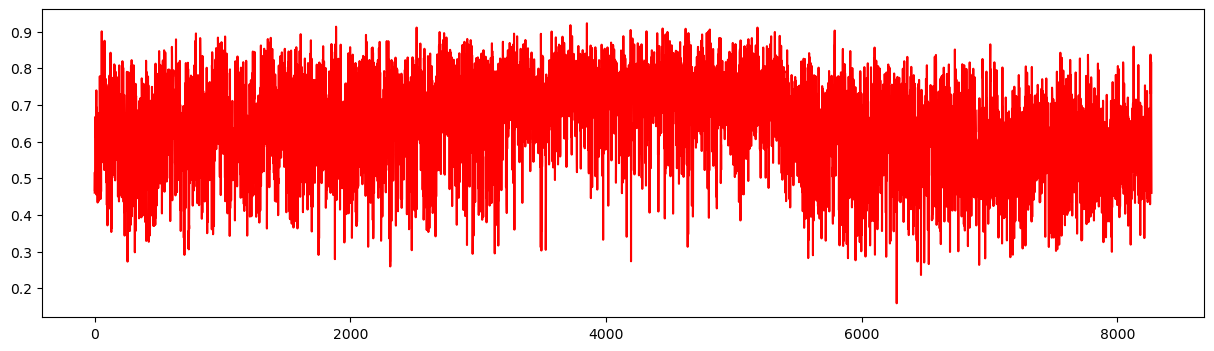

In [82]:
plt.figure(figsize=(15, 4))
#plt.plot(TEST_target, 'b-', lw=3.0)
plt.plot(Y_pred[:], 'r-')
#plt.plot(Y_pred>0.5)

In [77]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# ========== Training loop ========== #
for i in range(epochs):
    
    shuffle(filename_train)
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    L_full = len(filename_train)
    L_neg = len(filename_neg_train)
    L_pos = len(filename_pos_train)
    
    start_time = time.time()
    
    a = 0.2*np.ones(batch_size,)
    
    # loop of batch
    for j in range(L_train):
        
        ind_full = du.shuffle_ind(L_full)
        ind_pos = du.shuffle_ind(L_pos)
        ind_neg = du.shuffle_ind(L_neg)
        
        file_pick_pos = []
        for ind_temp in ind_pos[:batch_size_half]:
            file_pick_pos.append(filename_pos_train[ind_temp])

        file_pick_neg = []
        for ind_temp in ind_neg[:batch_size_half]:
            file_pick_neg.append(filename_neg_train[ind_temp])
            
        file_pick_full = []
        for ind_temp in ind_full[:batch_size]:
            file_pick_full.append(filename_train[ind_temp])
        
        file_pick = file_pick_pos + file_pick_neg
        
        for k in range(batch_size):
            # natural samples
            data = np.load(file_pick_full[k])
            for l, c in enumerate(ind_pick_from_batch):
                X_batch_c[k, ..., l] = data[..., c]
            
            if 'pos' in file_pick_full[k]:
                Y_batch_c[k, :] = 1.0
            elif 'neg_neg_neg' in file_pick_full[k]:
                Y_batch_c[k, :] = 0.0
            else:
                werhgaer
                
            # re-balanced samples
            data = np.load(file_pick[k])
            for l, c in enumerate(ind_pick_from_batch):
                X_batch_r[k, ..., l] = data[..., c]
            
            if 'pos' in file_pick[k]:
                Y_batch_r[k, :] = 1.0
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch_r[k, :] = 0.0
            else:
                werhgaer
                
        ind_ = du.shuffle_ind(batch_size)
        X_batch_c = X_batch_c[ind_, ...]
        Y_batch_c = Y_batch_c[ind_, :]
        
        X_batch_r = X_batch_r[ind_, ...]
        Y_batch_r = Y_batch_r[ind_, :]
        
        if np.sum(np.isnan(X_batch_c))+np.sum(np.isnan(X_batch_r)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch_c, X_batch_r, Y_batch_r, a], [Y_batch_r, Y_batch_r]);
    
    # epoch end operations
    Y_pred_list = model.predict([TEST_input, TEST_input, TEST_target, 0.0*np.ones(L_valid,)])
    Y_pred = Y_pred_list[1]
    # Y_pred[Y_pred<0] = 0
    # Y_pred[Y_pred>1] = 1
    record_temp = verif_metric(TEST_target, Y_pred)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

0.430021378989812
Validation loss 0.430021378989812 NOT improved
0.430021378989812
Validation loss 0.430021378989812 NOT improved
0.430021378989812
Validation loss 0.430021378989812 NOT improved


In [38]:
j

123844

In [ ]:
https://mesonet.agron.iastate.edu/pickup/wwa/

In [29]:
10 % 3

1